## Overview   

#### There are 7 .csv files, as listed below:
1. gender_age_train.csv  
2. gender_age_test.csv  
3. phone_brand_device_model.csv  
4. events.csv  
5. app_events.csv  
6. app_label.csv  
7. label_categories.csv  

#### This notebook explores these different datasets and tries to answer the following questions:    
1. What do the distributions of the users' gener and age look like?  
2. What are the popular phone brand and model?  
3. What is the relationship between gender/age and phone properties(phone brand/device model)?  
4. What do the users' geolocations look like?
5. What is the relationship between gender/age and their app events (e.g., number of events, number of installed apps, number \of active apps, the nature of category of apps?  
6. What kind of features can we use to build machine learning algorithms to predict gender and age group?

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

### 1. Gender/Age Information

In [2]:
# get data
ga_train = pd.read_csv('gender_age_train.csv', dtype = {'device_id': np.str})
print ga_train.shape
ga_train.head(3)

(74645, 4)


,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38


In [3]:
# any duplicates? any null values?
print('Number of duplicated rows: {}'.format(ga_train.device_id.nunique() - ga_train.shape[0]))
print('Number of null values in the dataframe: {}' .format(pd.isnull(ga_train).sum()))

Number of duplicated rows: 0
Number of null values in the dataframe: device_id    0
gender       0
age          0
group        0
dtype: int64


In [4]:
# what are the unique groups
print ga_train.group.unique()

['M32-38' 'M29-31' 'F24-26' 'F33-42' 'F27-28' 'M39+' 'M23-26' 'M27-28'
 'M22-' 'F43+' 'F23-' 'F29-32']


#### Visualize the gender/age distribution

M    47904
F    26741
Name: gender, dtype: int64


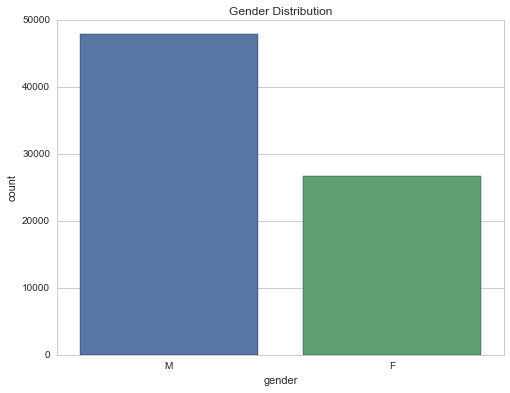

In [5]:
# gender distribution
mpl.rcParams['figure.figsize'] = (8.0, 6.0)

sns.countplot(ga_train.gender)
plt.title('Gender Distribution')

print ga_train.gender.value_counts()

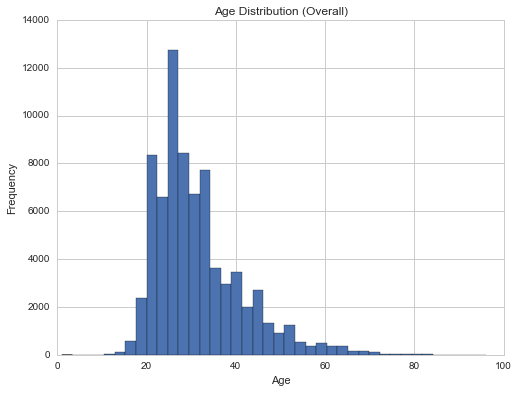

In [6]:
# age distribution for all users
ga_train['age'].plot(kind = 'hist', bins = 40)
plt.xlabel('Age')
plt.title('Age Distribution (Overall)')

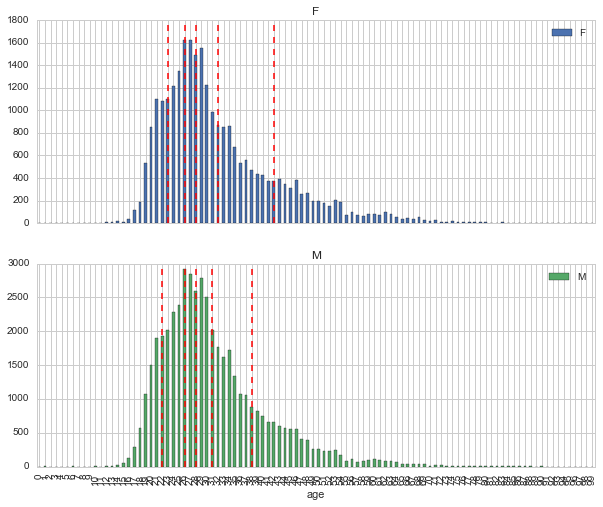

In [7]:
# age distribution by gender
g = ga_train.groupby(['age', 'gender']).size().unstack().reindex(index = np.arange(0, 100)).fillna(0)
ax1, ax2 = g.plot(kind = 'bar', subplots = True, figsize = (10, 8));
ax1.vlines(np.array([23, 26, 28, 32, 42]), 0, 1800, linestyles = 'dashed', linewidth = 1.5, colors = 'r')
ax2.vlines(np.array([22, 26, 28, 31, 38]), 0, 3000, linestyles = 'dashed', linewidth = 1.5, colors = 'r')

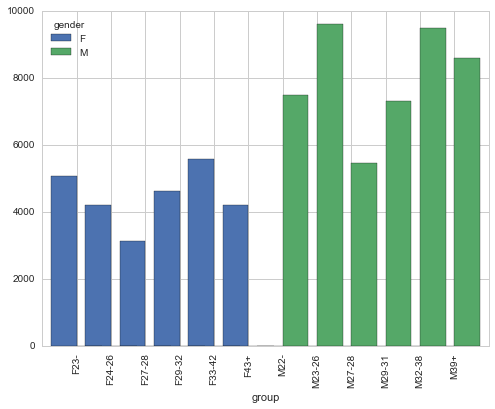

In [8]:
# user distribution by group
g2 = ga_train.groupby(['group', 'gender']).size().unstack().fillna(0)
g2.plot(kind = 'bar', width = 1.5)

### 2. Phone Properties

In [9]:
# get data
phone = pd.read_csv('phone_brand_device_model.csv', dtype = {'device_id': np.str})
print phone.shape
phone.head(3)

(187245, 3)


,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4


In [10]:
# any duplicates? any null values?
print('Number of duplicates: {}' .format(phone.shape[0] - phone.device_id.nunique()))
print('Number of null values: {}' .format(pd.isnull(phone).sum()))

Number of duplicates: 529
Number of null values: device_id       0
phone_brand     0
device_model    0
dtype: int64


In [11]:
# look closely into the duplicates
duplicate = phone.groupby(['device_id']).size()
duplicate = duplicate[duplicate > 1]
print('Min number of time a duplicated device_id appears: {}' .format(duplicate.min()))
print('Max number of time a duplicated device_id appears: {}' .format(duplicate.max()))

Min number of time a duplicated device_id appears: 2
Max number of time a duplicated device_id appears: 2


In [12]:
# do these duplicated device_ids correspond to the same brand & model?
duplicate = phone.loc[phone.device_id.isin(duplicate.index)]

d1 = duplicate.groupby(['device_id']).first()
d2 = duplicate.groupby(['device_id']).last()
diff = (d1 != d2).sum(axis = 1).nonzero()

print('Number of duplicated device_ids with distinct brand or model: {}'.format(len(diff[0])))

Number of duplicated device_ids with distinct brand or model: 6


In [13]:
# what are these device_ids
pd.concat((d1.iloc[diff], d2.iloc[diff]), axis = 1)

,phone_brand,device_model,phone_brand,device_model
device_id,,,,
-3004353610608679970,酷派,5891,酷派,7296
-5269721363279128080,三星,Galaxy Core Advance,小米,MI 3
-6590454305031525112,小米,MI 3,华为,荣耀6 Plus
-7059081542575379359,LG,Nexus 5,魅族,魅蓝Note 2
-7297178577997113203,华为,荣耀畅玩5X,华为,荣耀3C
5245428108336915020,魅族,MX4,小米,MI One Plus


In [14]:
# only 6 of the duplicated device_ids actually correspond to different brand or model
# so just simply drop all duplicated device_ids 

phone = phone.drop_duplicates('device_id', keep = 'first')
print phone.shape

(186716, 3)


#### Look into the brand and model

In [15]:
# distinct brand and distinct model
print('Number of distinct brand: {}' .format(phone.phone_brand.nunique()))
print('Number of distinct model: {}' .format(phone.device_model.nunique()))

Number of distinct brand: 131
Number of distinct model: 1599


In [16]:
# what are the popular brands
brand_popular = phone.phone_brand.value_counts()
brand_popular.sort_values(ascending = False, inplace = True)
brand_popular[0 : 10]

小米      43107
三星      34191
华为      32465
vivo    14342
OPPO    14239
魅族      11816
酷派       8382
联想       6752
金立       2763
HTC      2675
Name: phone_brand, dtype: int64

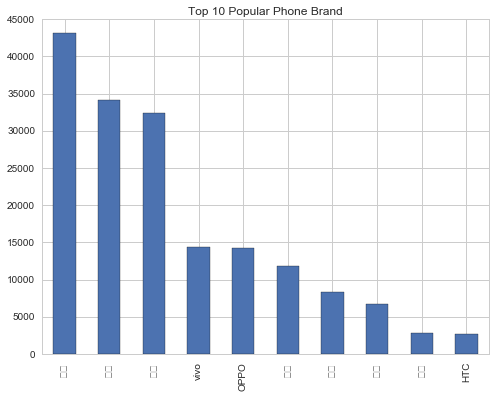

In [17]:
brand_popular[0 : 10].plot(kind = 'bar')
plt.title('Top 10 Popular Phone Brand')

In [18]:
# is there any model that belongs to different brand?
g_model = phone.groupby(['device_model'])['phone_brand'].apply(pd.Series.nunique)
g_model = g_model[g_model >1]
print('Number of devices models belonging to more than one brand: {}' .format(len(g_model)))

Number of devices models belonging to more than one brand: 54


In [19]:
# code these brands and models
def code(table, f):
    mapping = {}
    label = sorted(table[f].unique())
    for i in range(len(label)):
        mapping[label[i]] = i
    table = table.replace({f: mapping})
    return table

In [20]:
phone = code(phone, 'phone_brand')
phone = code(phone, 'device_model')
phone.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,51,1517
1,1277779817574759137,51,749
2,5137427614288105724,15,560
3,3669464369358936369,9,1503
4,-5019277647504317457,15,536
